# Point cloud classification using SQN

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#SQN-architecture" data-toc-modified-id="SQN-architecture-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>SQN architecture</a></span><ul class="toc-item"><li><span><a href="#Point-Local-Feature-Extractor" data-toc-modified-id="Point-Local-Feature-Extractor-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Point Local Feature Extractor</a></span></li><li><span><a href="#Point-Feature-Query-Network" data-toc-modified-id="Point-Feature-Query-Network-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Point Feature Query Network</a></span></li></ul></li><li><span><a href="#Implementation-in-arcgis.learn" data-toc-modified-id="Implementation-in-arcgis.learn-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Implementation in <code>arcgis.learn</code></a></span><ul class="toc-item"><li><span><a href="#For-advanced-users" data-toc-modified-id="For-advanced-users-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>For advanced users</a></span></li></ul></li><li><span><a href="#Setting-up-the-environment" data-toc-modified-id="Setting-up-the-environment-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Setting up the environment</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#For-ArcGIS-Pro-users:" data-toc-modified-id="For-ArcGIS-Pro-users:-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>For ArcGIS Pro users:</a></span></li><li><span><a href="#For-Anaconda-users-(Windows-and-Linux-platforms):" data-toc-modified-id="For-Anaconda-users-(Windows-and-Linux-platforms):-4.0.2"><span class="toc-item-num">4.0.2&nbsp;&nbsp;</span>For Anaconda users (Windows and Linux platforms):</a></span></li></ul></li></ul></li><li><span><a href="#Best-practices-for-SQN-workflow" data-toc-modified-id="Best-practices-for-SQN-workflow-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Best practices for SQN workflow</a></span></li><li><span><a href="#References" data-toc-modified-id="References-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>References</a></span></li></ul></div>

## Introduction

SQN <a href="#References">[1]</a> is a point cloud classification model available in the `arcgis.learn` module, designed to efficiently classify a vast amount of point clouds. Typically, LiDAR sensors use laser technology to survey the earth's surface, generating precise 3D coordinates (x, y, and z) that form point clouds. These points also have some additional information like 'GPS timestamps', 'intensity', and 'number of returns'. The intensity represents the returning strength from the laser pulse that scanned the area, and the number of returns shows how many times a given pulse returned. LiDAR data can also be fused with RGB (red, green, and blue) bands, derived from imagery taken simultaneously with the LiDAR survey. 

Point cloud classification are based on the type of object that reflected the laser pulse. For example, a point that reflects off the ground is classified into the ground category. LiDAR points can be classified into different categories like buildings, trees, highways, water, etc. These different classes have numeric codes assigned to them.

<p align="center">
<center>
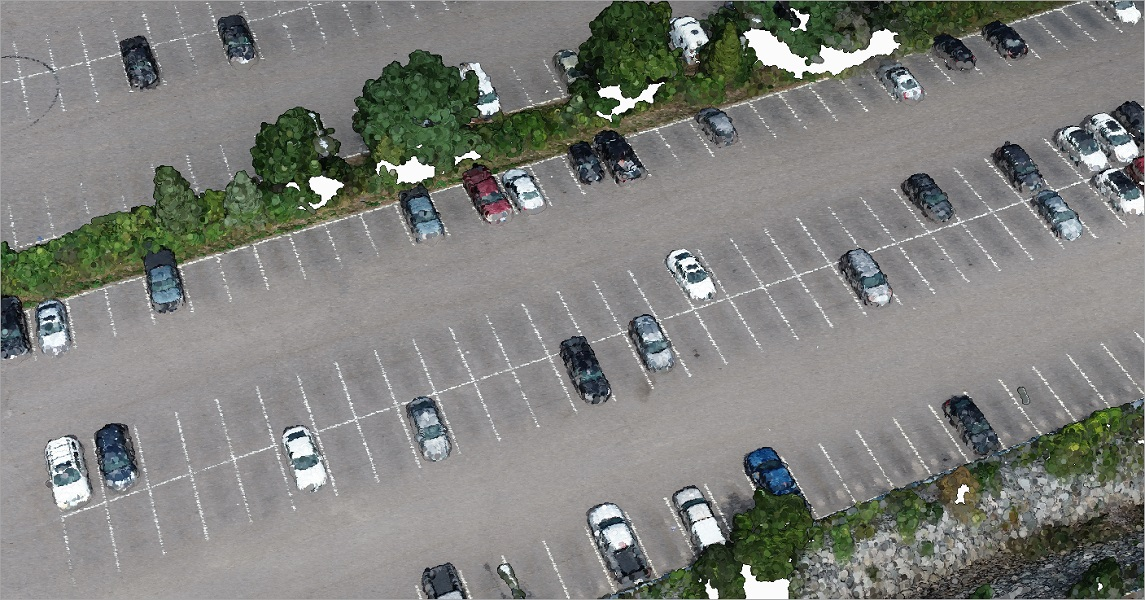
</center>
</p>
<br>
<center>Figure 1. Visualization of point cloud dataset, fused with imagery having RGB bands.</center>

Point cloud classification is a task where each point in the point cloud is assigned a label, representing a real-world entity (see Figure 1.). And similar to how it's done in traditional methods, for deep learning, the point cloud classification process involves training – where the neural network learns from an already classified (labeled) point cloud dataset, where each point has a unique class code. These class codes are used to represent the features that we want the neural network to recognize. 

In deep learning workflows for point cloud classification, one should not use a ‘thinned-out’ representation of a point cloud dataset that preserves only class codes of interest but drops a majority of the undesired return points, as we would like the neural network to learn and be able to differentiate points of interest and those that are not. Likewise, additional attributes that are present in training datasets, for example, Intensity, RGB, number of returns, etc. will improve the model’s accuracy but could inversely affect it if those parameters are not correct in the datasets that are used for inferencing.

When it comes to classifying point clouds, deep learning and neural networks are a great choice since they offer a scalable and efficient architecture. They have enormous potential to make manual or semi-assisted classification modes of point clouds a thing of the past. With that in mind, we can take a closer look at the SQN model included in `arcgis.learn` and how it can be used for point cloud classification.

SQN is a novel approach for semantic segmentation of 3D point cloud data, which can achieve high performance even with a small percentage of labeled data for training. It is based on a feature extractor that encodes the raw point cloud into a set of hierarchical latent representations, which can be queried using an arbitrary point position within a local neighborhood. The queried representations are then summarized into a compact vector, which is fed into a multilayer perceptron (MLP) to predict the final semantic label. Additionally, SQN takes into account the semantic similarity between neighboring 3D points, which allows it to back-propagate the sparse training signals to a wider spatial region and hence achieve superior performance under weak supervision <a href="#References">[1]</a>.

## SQN architecture

<p align="center">
<center>
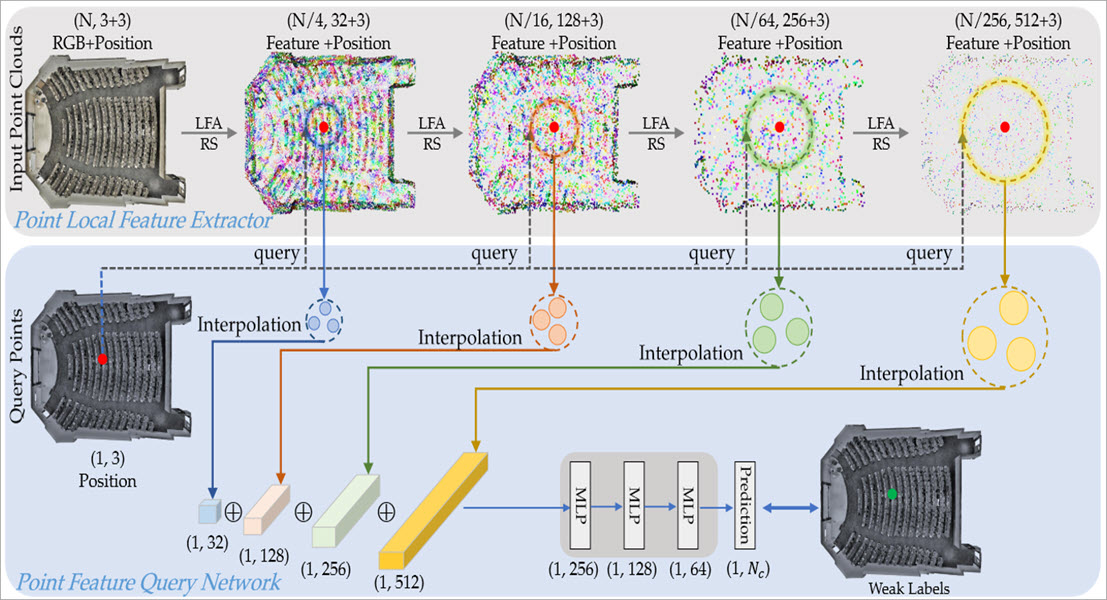
</center>
</p>
<br>
<center>Figure 2. Architecture of SQN, depicting the training stage with weak supervision. Here, only one query point is shown for simplicity <a href="#References">[1]</a>.</center>

SQN refers to a weakly-supervised learning approach that utilizes point clouds with sparse annotations. It involves a simple architecture consisting of a point local feature extractor which helps in learning diverse visual patterns and a point feature query network that collects relevant semantic features for weakly-supervised training. The aim of this approach is to update network parameters effectively and efficiently utilizing the sparse yet valuable training signals such that more geometrically meaningful local patterns can be learned.


The Point Local Feature Extractor component of SQN aims to extract local features for all points using a hierarchical approach, while the Point Feature Query Network is designed to collect relevant features with the help of a 3D query point, using the training signals to be shared and back-propagated for the relevant points.

After the features are extracted using the Point Local Feature Extractor and relevant features are collected using the Point Feature Query Network, the unique and representative feature vector for the query point is obtained. This feature vector is then fed into the final component of SQN, which is a series of MLPs that directly infer the point semantic category (see Figure 2.) <a href="#References">[1]</a>.


### Point Local Feature Extractor

The Point Local Feature Extractor in SQN is a hierarchical approach for extracting local features from all points in an input point cloud. It consists of multiple layers of Local Feature Aggregation (LFA) followed by a Random Sampling (RS) operation. The LFA layers enable the extraction of hierarchical point features, with four levels of feature vectors extracted after each encoding layer. The four levels are N x 32, N x 128, N x 256, and N x 512, where N represents the number of points in the input point cloud. The RS operation preserves the point location data in each feature vector. This component is not restricted to any specific backbone network, and is designed to extract diverse visual patterns from the input point cloud, allowing the network to learn more geometrically meaningful local patterns from sparse training signals (see Figure 2.).

### Point Feature Query Network

The Point Feature Query Network in SQN is designed to collect relevant features that can be trained using the available sparse signals. It is responsible for querying neighboring point features around a specific 3D query point, interpolating the queried K vectors, and inferring the point semantic category. To accomplish this, it performs three key functions. Firstly, the network searches the nearest K points in each of the four levels of encoded features according to pointwise Euclidean distance. Secondly, it compresses the queried K vectors into a compact representation for the query point using trilinear interpolation. Finally, it feeds the representative feature vector for the query point into a series of MLPs to infer the point semantic category (see Figure 2.). The query mechanism allows the network to infer the point semantic category from a significantly larger receptive field, and back-propagate valuable training signals to a much wider spatial context.

## Implementation in `arcgis.learn`

When training a SQN model using `arcgis.learn`, the raw point cloud dataset in LAS files is first converted into blocks of points, containing a specific number of points along with their class codes.

<p align="center">
<center>
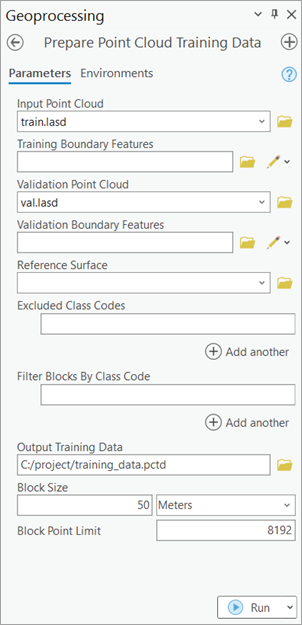
</center>
</p>
<br>
<center>Figure 3. <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/prepare-point-cloud-training-data.htm" target="_blank">Prepare Point Cloud Training Data</a> tool in ArcGIS Pro.</center>

For this step of exporting the data into an intermediate format, use <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/prepare-point-cloud-training-data.htm" target="_blank">Prepare Point Cloud Training Data</a> tool, in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst extension</a>, available from ArcGIS Pro 2.8 onwards (see Figure 3.).

These exported blocks are used to create a `data bunch` object that is passed into the `SQNSeg` model for training.

```python
output_path=r'C:/project/training_data.pctd'
data = prepare_data(output_path, dataset_type='PointCloud', batch_size=2)
sq = SQNSeg(data)
sq.fit(20)
```
After training the SQN model, `compute_precision_recall()` method can be used to compute, per-class metrics (precision, recall, and f1-score) with respect to validation data. And `save()` method can be used to save the model.

<p align="center">
<center>
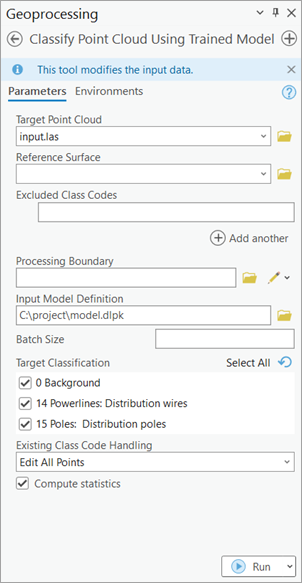
</center>
</p>
<br>
<center>Figure 4. <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model</a> tool.</center>

For inferencing, use <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model</a> tool, in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst extension</a>, available from ArcGIS Pro 2.8 onwards (see Figure 4.).

Main features available during the inferencing step:
       
- _Target classification:_ selective classification for flexibility and control in trained model's predictions.


- _Preserving specific classes in input data from modification:_ this can be used for updating old datasets and for noise control in model's prediction.

Detailed tool references and resources for point cloud classification using deep learning in ArcGIS Pro can be found <a href="https://pro.arcgis.com/en/pro-app/latest/help/data/las-dataset/introduction-to-deep-learning-and-point-clouds.htm" target="_blank">here</a>.

### For advanced users 

We can also specify, additional parameters that directly affects the properties of the architecture itself, this can be done while initializing the `SQNSeg` model while using the API, by using `encoder_params` keyword argument.

It is an optional dictionary which can be used to specify:

- `out_channels` that can set the number of channels produced by each layer.


- `sub_sampling_ratio` which sets the sampling ratio of random sampling at each layer.


- `k_n` controls the number of K-nearest neighbor for a point.


A typical usage with respect to API looks like:

```python
sq = SQNSeg(data=data, 
               encoder_params={'out_channels':[16, 64, 128, 256],
                               'sub_sampling_ratio':[4, 4, 4, 4],
                               'k_n':16,
                              }
               )
```

## Setting up the environment

<i>Make sure to update your 'GPU driver' to a recent version and use 'Administrator Rights' for all the steps, written in this guide.</i>

_**Below, are the instructions to set up the required 'conda environment':**_

#### For ArcGIS Pro users:

<a href="https://github.com/esri/deep-learning-frameworks" target="_blank">Deep learning frameworks</a>
can be used to install all the required dependencies in  ArcGIS Pro's default python environment using an MSI installer. 

Alternatively,  
for a cloned environment of ArcGIS Pro's default environment, `deep-learning-essentials` metapackage can be used to install the required dependencies which can be done using the following command, in the _`Python Command Prompt`_ <i>(included with ArcGIS Pro)</i>:

`conda install deep-learning-essentials`

#### For Anaconda users (Windows and Linux platforms):

`arcgis_learn` metapackage can be used for both `windows` and `linux` installations of `Anaconda` in a new environment.

The following command will update `Anaconda` to the latest version. 

`conda update conda`

After that, metapackage can be installed using the command below:

`conda install -c esri arcgis_learn python=3.9`

_(Alternatively, 3.7 and 3.8 versions of `python` are also supported with the metapackage.)_

## Best practices for SQN workflow

The following tips and best practices can be used while using SQN:

- The <a href="https://pro.arcgis.com/en/pro-app/latest/help/data/las-dataset/introduction-to-deep-learning-and-point-clouds.htm" target="_blank">3D deep learning tools</a> in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst extension</a>, takes care of the coordinate system, and related discrepancies, automatically. So, one can train a model using ArcGIS Pro on a dataset with a metric coordinate system, then use that trained model on a dataset with any other coordinate system, and vice-versa without any need for re-projection.

- High-quality labeled data will result in a better-trained model. For generalization and robustness of the trained model, significant diversity or variety should be present in the training data, in terms of geography, building architectures, terrains, object-related variations, etc.

- If the object of interest is significantly larger or smaller in size than the default value of `Block Size`, then a better value can be used for improving the results further. Like, for a dataset in a metric coordinate system, a _'warehouse'_ won't fit in a '50 meter' x '50 meter' `Block Size`, hence the `Block Size` can be increased in this case. 

- Through a series of experiments, it was found that an additional one or two `extra_features` apart from X, Y, and Z usually works best, in most cases. Over usage of 'extra attributes' for model training might reduce generalization, i.e. _'how generic the trained model will be'_. 

- Deciding which 'extra attributes' to consider, depends upon the properties of the object of interest, the nature of noise, sensor-specific attributes, etc. 

- It is recommended to filter or withheld points that belong to the 'high noise' class from the dataset.

- If the training and validation dataset is very large and each epoch is taking a lot of time to complete, then `iters_per_epoch` can be used to see the epoch/training table quickly by reducing the time taken for the completion of an epoch. This is achieved by a random selection/filtering of fewer batches, governed by the user-provided value of `iters_per_epoch`. So in each epoch, the model is exposed to a lesser number of randomly selected batches, this results in faster completion of an epoch, but it can lead to more numbers of epochs before the model converges. 

- `mask_class` functionality in `show_results()` can be used for analyzing any inter-class noises present in the validation output. This can be used to understand which classes need more diversity in training data or need an increase in its number of labeled points _(As shown below, in Figure 5.)_.


<p align="center"><center><img src="../../static/img/pointcnn_guide_gif_1.gif" /></center></p>

<center>Figure 5. Class-based masking of points, to understand the nature of noise in the prediction.</center>

- The default value of `max_display_point` in `show_batch()` and `show_results()` is set to '20000', keeping the rendering-related browser limitation in mind, which can occur for very dense point clouds. This value can be increased if needed, for detailed visualization, within the browser itself. 

- `Target Classification` and `Class Preservation` in <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model</a> tool, can be used in conjunction to combine the knowledge of multiple trained models for a single scene. 

- Parameters like, `classes_of_interest` and `min_points` are especially useful when training a model for SfM or mobile/terrestrial point clouds. In specific scenarios when the 'training data' is not small, these features can be very useful in speeding up the 'training time', improving the convergence during training, and addressing the class imbalance up to some extent.

- Fine-tuning a pretrained model is only preferred if the 'object of interest' is either same or similar, else it is not beneficial. Otherwise, fine-tuning a pretrained model can save cost, time, and compute resources while providing better accuracy/quality in results.

- Class codes can be given a meaningful name, using `class_mapping`. The names of the class codes are saved inside the model, which is automatically retrieved by <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model</a> tool and <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/train-point-cloud-classification-model.htm" target="_blank">Train Point Cloud Classification Model</a> tool, when a trained model is loaded.






- For fine-tuning a model with default architecture settings;  'Class Structure', 'Extra Attributes', and 'Block Point Limit' should match between the pretrained model and the exported 'training data'.

## References


[1] Hu, Q., Yang, B., Fang, G., Guo, Y., Leonardis, A., Trigoni, N., & Markham, A. (2022). SQN: Weakly-Supervised Semantic Segmentation of Large-Scale 3D Point Clouds. In Lecture Notes in Computer Science (including subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics): Vol. 13687 LNCS (pp. 600–619). https://doi.org/10.1007/978-3-031-19812-0_35